# Finding the best locations for new pharmacies (IBM Data Science Capstone Project)

## Introduction / Business Problem

### Problem

The city of Vienna (capital city of Austria, Europe) has been experiencing a lot of growth in the recent years, which makes it attractive for old and new businesses alike. But this growth also comes with a number of challenges, one of them being the development of the healthcare system to accomodate an increasing number of inhabitants. Judging by the fact that the predictions about population increase had to be adjusted upwards every year since 1989 (see image below, in German), it becomes clear that planning has to start now in order to avoid shortages.

![demographic development city of Vienna](https://www.wien.gv.at/statistik/bevoelkerung/images/bev-entw-hist-prog.png)

Since rental space for businesses is not unlimited (especially in the center of the city), prices are ever increasing, making it essential to pick the right location for setting up new business. In addition, setting up businesses like pharmacies is regulated by local legislation, applying for a permit to set up a new pharmacy is a costly and time consuming process in itself, but even more so if a bad spot was chosen. While this is an optimization problem in itself, it all starts with knowing where demand will be coming from and evaluating locations from there.

Lastly, there has been a lot of political debate whether or not doctors should be allowed to sell drugs directly to their patients, breaking the current legal monopoly currently held by pharmacies. As with most things, there are arguments for either side, but we hope to contribute to the discussion with some data-driven analysis.

### Audience

- Investors in the pharmaceutical industry, interested in making an informed decision about whether and where to invest in Vienna by setting up new pharmacies.
- Public administration and city developers, wanting to decide where space should allocated to maximize public service in the coming decade.
- Universities in and around Vienna, trying to plan how many students of pharmacology will best suit the needs of Vienna.
- Politicians in Vienna, interested in some facts about how many pharmacies will be needed in the near future.



## Data

To perform our analysis, we will need some data. Luckily, we live in the information age and there is a wealth of data available online. For this project, we will be using two data sources, Foursquare and Open Data Austria.

### Foursquare

Foursquare specializes in location based data that is enriched with user based imagery and reviews. For our project, we will pull data from Foursquare that allows us to find the current location of pharmacies and match them up with the various districts of Vienna. Using this data, we'll be able to calculate densities, like persons per pharmacy, today and 15 years in the future, which allows us to recommend locations where additional pharmacies might be needed.

Note to non-German speaking readers: "Apotheke"/"Wien" are the German words for "Pharmacy"/"Vienna", should you encounter them. 

In [111]:
%%html
<iframe src="https://de.foursquare.com/explore?mode=url&near=Wien%2C%20%C3%96sterreich&nearGeoId=72057594040689305&q=apotheke" width="1280" height="600"></iframe>

In [216]:
#Libraries used throughout the analysis
import pandas as pd
import numpy  as np
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
#!conda install -c conda-forge geopandas descartes --yes
import geopandas as gpd
import requests
import json

address = 'Vienna,AT'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Location of Vienna, Austria: ', latitude, longitude)

#Foursquare parameters
CLIENT_ID = 'EOGS2ZA3IH1DZAGOT0G0MLFHMRLQSAV1TMGAIW4N2EJEGPFG' # your Foursquare ID
CLIENT_SECRET = 'M2QXMSBBAOTLRW5RCOSNJUGYM0SRZB3WMT3QMR4SB1HVOYIT' # your Foursquare Secret


Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Location of Vienna, Austria:  48.2083537 16.3725042


In [273]:
VERSION = '20180604'
LIMIT = 500
INTENT = 'browse'
search_query = 'Apotheke'
address = 'Vienna,AT'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&query={}&limit={}&near={}&intent={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, search_query, LIMIT, address, INTENT)
print(url)
results = requests.get(url).json()
results

https://api.foursquare.com/v2/venues/search?client_id=EOGS2ZA3IH1DZAGOT0G0MLFHMRLQSAV1TMGAIW4N2EJEGPFG&client_secret=M2QXMSBBAOTLRW5RCOSNJUGYM0SRZB3WMT3QMR4SB1HVOYIT&v=20180604&query=Apotheke&limit=500&near=Vienna,AT&intent=browse


{'meta': {'code': 200, 'requestId': '5d7602dc6adbf5002c1f7128'},
 'response': {'venues': [{'id': '4f4e057ce4b051dc48ef4e3f',
    'name': 'Apotheke zum weissen Storch',
    'location': {'address': 'Tuchlauben',
     'crossStreet': 'Steindlgasse',
     'lat': 48.209947,
     'lng': 16.370146,
     'labeledLatLngs': [{'label': 'display',
       'lat': 48.209947,
       'lng': 16.370146}],
     'postalCode': '1010',
     'cc': 'AT',
     'city': 'Wien',
     'state': 'Wien',
     'country': 'Österreich',
     'formattedAddress': ['Tuchlauben (Steindlgasse)',
      '1010 Wien',
      'Österreich']},
    'categories': [{'id': '4bf58dd8d48988d10f951735',
      'name': 'Pharmacy',
      'pluralName': 'Pharmacies',
      'shortName': 'Pharmacy',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/pharmacy_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1568015068',
    'hasPerk': False},
   {'id': '59e1cca26c08d1147f41656e',
    'name': 'Apotheke zu

In [268]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
print(dataframe.shape)
dataframe.head()

(50, 18)


,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,4f4e057ce4b051dc48ef4e3f,Tuchlauben,AT,Wien,Österreich,Steindlgasse,"[Tuchlauben (Steindlgasse), 1010 Wien, Österre...","[{'label': 'display', 'lat': 48.209947, 'lng':...",48.209947,16.370146,NaN,1010,Wien,Apotheke zum weissen Storch,v-1568014489,NaN
1,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,59e1cca26c08d1147f41656e,NaN,AT,Wien,Österreich,NaN,"[1010 Wien, Österreich]","[{'label': 'display', 'lat': 48.206985, 'lng':...",48.206985,16.374628,Kärntner Viertel,1010,Wien,Apotheke zum goldenen Reichsapfel,v-1568014489,NaN
2,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,4d4be6a39bbb721e53cf8ca0,Landstrasser Hauptstrasse 4,AT,Wien,Österreich,NaN,"[Landstrasser Hauptstrasse 4, 1030 Wien, Öster...","[{'label': 'display', 'lat': 48.20570283423872...",48.205703,16.386199,NaN,1030,Wien,Apotheke zur Hl. Elisabeth,v-1568014489,NaN
3,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,4bc5da0c0a30d13a378d5a9c,Werdertorgasse 5,AT,Wien,Österreich,NaN,"[Werdertorgasse 5, 1010 Wien, Österreich]","[{'label': 'display', 'lat': 48.2147999, 'lng'...",48.214800,16.369380,NaN,1010,Wien,Werdertor-Apotheke,v-1568014489,NaN
4,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",False,4bf4da66cad2c928476d9c99,Mariahilfer Straße 110,AT,Wien,Österreich,NaN,"[Mariahilfer Straße 110, 1070 Wien, Österreich]","[{'label': 'display', 'lat': 48.19675, 'lng': ...",48.196750,16.343380,NaN,1070,Wien,Apotheke zur Kaiserkrone,v-1568014489,NaN


Unfortunately, there seems to be a limitation of 50 records maximum that can be retrieved from the Foursquare API. Other query approaches like sw-ne boxing won't work due to the districts not fitting well into rectangular shapes and/or causing issues with overlap. As a result, we'll have to find another source to work with for our analysis in order to avoid huge development efforts.

### Open Data Austria

[Open Data Austria](https://www.data.gv.at) is a website operated by the administration of Vienna, to make their data publicly available as Open Data. We will be mostly pulling census data from there, which includes current number of inhabitants per district as well as predictions 15 years into the future.

- Population projection by sex and country of birth for districts in Vienna 2014 to 2034: https://www.wien.gv.at/statistik/ogd/vie_302.csv
- Pharmacy locations Vienna: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:APOTHEKEOGD&srsName=EPSG:4326&outputFormat=csv
- Vienna District boundaries: https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:BEZIRKSGRENZEOGD&srsName=EPSG:4326&outputFormat=json

In [213]:
df_pop = pd.read_csv('https://www.wien.gv.at/statistik/ogd/vie_302.csv', sep=';', header=1, encoding='latin-1')
print(df_pop.shape)
df_pop.head()

(483, 11)


,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,POP_TOTAL,POP_MEN,POP_WOMEN,POP_NATIVE,POP_FOREIGN,REF_Date
0,AT1,AT13,AT130,90100,.,16434,7863,8571,10982,5452,20140101
1,AT1,AT13,AT130,90200,.,100016,48796,51220,61508,38508,20140102
2,AT1,AT13,AT130,90300,.,87213,41463,45750,56868,30345,20140103
3,AT1,AT13,AT130,90400,.,31947,15172,16775,20270,11677,20140104
4,AT1,AT13,AT130,90500,.,54153,26585,27568,31927,22226,20140105


In [225]:
df_pharm = gpd.read_file('https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:APOTHEKEOGD&srsName=EPSG:4326&outputFormat=json')
print(df_pharm.shape)
df_pharm.head()

(329, 13)


,id,OBJECTID,BEZEICHNUNG,BEZIRK,STRASSE,ONR,ADRESSE,TELEFON,FAX,EMAIL,WEBLINK1,SE_ANNO_CAD_DATA,geometry
0,APOTHEKEOGD.fid--572843c0_16d1440830a_7693,797777,"Apotheke ""Zur heiligen Corona""",15,Sechshauser Straße,104,"15., Sechshauser Straße 104",01 893 60 26,01 893 60 26,corona.apotheke@chello.at,None,None,POINT (16.32422229502762 48.18639458382223)
1,APOTHEKEOGD.fid--572843c0_16d1440830a_7694,797778,St. Rudolf-Apotheke,15,Goldschlagstraße,102,"15., Goldschlagstraße 102",01 982 43 82,01 982 43 82,st.rudolf-apotheke@aon.at,None,None,POINT (16.31801869622347 48.19432392998068)
2,APOTHEKEOGD.fid--572843c0_16d1440830a_7695,797779,Lindwurm-Apotheke,15,Gablenzgasse,31,"15., Gablenzgasse 31",01 982 24 21,01 982 24 21,Lindwurm.Apotheke@aon.at,http://www.lindwurm-apo.at,None,POINT (16.32851752854145 48.20469160523618)
3,APOTHEKEOGD.fid--572843c0_16d1440830a_7696,797780,"Apotheke ""Maria vom Siege""",15,Mariahilfer Straße,154,"15., Mariahilfer Straße 154",01 892 34 47,01 892 34 47,georg.steinhart@aon.at,None,None,POINT (16.33414959576491 48.19366820365136)
4,APOTHEKEOGD.fid--572843c0_16d1440830a_7697,797781,"Apotheke ""Zur Mariazell""",15,Sechshauser Straße,41,"15., Sechshauser Straße 41",01 893 23 91,01 893 23 91,apo.mariazell@aon.at,None,None,POINT (16.33073420824175 48.18729826650488)


In [237]:
vienna_json_url = 'https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:BEZIRKSGRENZEOGD&srsName=EPSG:4326&outputFormat=json'
df_dist = gpd.read_file(vienna_json_url)
print(df_dist.shape)
df_dist.head()

(23, 18)


,id,NAMEK,BEZNR,BEZ_RZ,NAMEK_NUM,NAMEK_RZ,NAMEG,LABEL,BEZ,DISTRICT_CODE,STATAUSTRIA_BEZ_CODE,STATAUSTRIA_GEM_CODE,FLAECHE,UMFANG,AKT_TIMESTAMP,SE_SDO_ROWID,SE_ANNO_CAD_DATA,geometry
0,BEZIRKSGRENZEOGD.9290,Neubau,7,VII,"7., Neubau",VII. Neubau,NEUBAU,VII.,07,1070,907,90701,1.608248e+06,5312.54,2019-04-09,9290,None,"POLYGON ((16.33872503860187 48.20853687769482,..."
1,BEZIRKSGRENZEOGD.9291,Landstraße,3,III,"3., Landstraße",III. Landstraße,LANDSTRASSE,III.,03,1030,903,90301,7.397742e+06,13975.96,2019-04-09,9291,None,"POLYGON ((16.39661691195656 48.20738650411634,..."
2,BEZIRKSGRENZEOGD.9292,Josefstadt,8,VIII,"8., Josefstadt",VIII. Josefstadt,JOSEFSTADT,VIII.,08,1080,908,90801,1.089946e+06,4170.30,2019-04-09,9292,None,"POLYGON ((16.34914738057747 48.21515778657998,..."
3,BEZIRKSGRENZEOGD.9293,Innere Stadt,1,I,"1., Innere Stadt",I. Innere Stadt,INNERE STADT,I.,01,1010,901,90101,2.868774e+06,6972.75,2019-04-09,9293,None,"POLYGON ((16.37264062192926 48.21661673091233,..."
4,BEZIRKSGRENZEOGD.9294,Ottakring,16,XVI,"16., Ottakring",XVI. Ottakring,OTTAKRING,XVI.,16,1160,916,91601,8.673048e+06,18371.08,2019-04-09,9294,None,"POLYGON ((16.27620638442814 48.22703677399255,..."


## Methodology 
represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

### Data Preparation
The raw data we get from Open Data Austria is quite technical in nature and contains numerous columns we won't need. In addition, some of the data needs reformatting for easier consumption in our analysis.

#### Population data
First, let's get rid of the stuff we don't need and rename the remaining columns to something more legible. Then, let's extract the real district number from the District field and strip off everything after the 4th digit from the Year field. Finally, let's get rid of rows that are out of date.

In [223]:
df_pop.drop(['NUTS1', 'NUTS2', 'NUTS3', 'SUB_DISTRICT_CODE', 'POP_MEN', 'POP_WOMEN', 'POP_NATIVE', 'POP_FOREIGN'], axis=1, inplace=True)
df_pop.rename(columns={'DISTRICT_CODE':'District', 'POP_TOTAL':'Population', 'REF_Date':'Year'}, inplace=True)
df_pop['District'] = df_pop['District'].astype(str).str[1:3].astype(int)
df_pop['Year'] = df_pop['Year'].astype(str).str[0:4].astype(int)
df_pop = df_pop[df_pop['Year']>=2019]
df_pop.head()

,District,Population,Year
115,1,15958,2019
116,2,108651,2019
117,3,91915,2019
118,4,33190,2019
119,5,56462,2019


#### Pharmacy data
Looking at the raw data, we can basically get rid of all columns except District ("BEZIRK") and Location ("SHAPE"), as well as the ID ("OBJECTID") for consistency purposes. As with the population data, we'll rename the columns to something more legible. Finally, we'll also extract Longitude and Latitude from the Location column.

In [229]:
df_pharm_clean = df_pharm[['OBJECTID', 'BEZIRK', 'geometry']]
df_pharm_clean = df_pharm_clean.rename(columns={'OBJECTID':'ID', 'BEZIRK':'District'})
#df_pharm_clean['Longitude'] = df_pharm_clean['geometry'].str.split(" ", n = -1, expand = True)[[1]]
df_pharm_clean['Longitude'] = df_pharm_clean['geometry'].centroid.x
#df_pharm_clean['Longitude'] = df_pharm_clean['Longitude'].str[1:].astype(float)
df_pharm_clean['Latitude'] = df_pharm_clean['geometry'].centroid.y
#df_pharm_clean['Latitude'] = df_pharm_clean['Latitude'].str[:-1].astype(float)
#df_pharm_clean.drop(['Location'], axis = 1, inplace = True)
df_pharm_clean.head()


,ID,District,geometry,Longitude,Latitude
0,797777,15,POINT (16.32422229502762 48.18639458382223),16.324222,48.186395
1,797778,15,POINT (16.31801869622347 48.19432392998068),16.318019,48.194324
2,797779,15,POINT (16.32851752854145 48.20469160523618),16.328518,48.204692
3,797780,15,POINT (16.33414959576491 48.19366820365136),16.334150,48.193668
4,797781,15,POINT (16.33073420824175 48.18729826650488),16.330734,48.187298


### Exploratory Analysis

#### Population development

Let's look at the population development in the various districts of Vienna from 2014 to 2034. To do this, we first pivot the original relational data into something that can be plotted more easily.

In [230]:
df_pop_byyear = df_pop.pivot(index='District', columns='Year', values='Population').transpose()
df_pop_byyear

District,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
Year,,,,,,,,,,,,,,,,,,,,,
2019,15958,108651,91915,33190,56462,32902,33129,26422,43160,201388,...,88668,77061,104909,57694,50668,70652,92949,158075,184859,103770
2020,15838,109814,92634,33305,56729,33235,33492,26617,43385,203359,...,88800,77198,105474,57968,50752,70509,94944,160316,189533,103970
2021,15712,111093,94264,33374,56902,33506,33650,26763,43538,205393,...,89536,77035,105631,58390,50762,70272,96427,162366,190821,106149
2022,15595,112060,95668,33448,57079,33773,33804,26905,43690,207152,...,90268,76901,105800,58815,50781,70059,98014,163373,193105,108349
2023,15486,113400,96864,33529,57263,34036,33955,27046,44204,209578,...,90319,76798,105986,58981,50811,69873,99311,163399,197517,109320
2024,15396,114116,97364,33654,57527,34339,34142,27220,44792,211516,...,90542,76819,106319,59228,50913,69778,100437,162808,203383,109835
2025,15278,115339,97633,33670,57581,34515,34227,27289,45314,214112,...,90550,76635,106318,59264,50848,69580,100835,164623,207568,110997
2026,15170,115846,98571,33704,57855,34703,34322,27368,45835,216725,...,90606,77125,106377,59331,50814,69426,101275,166391,209780,111396
2027,15066,116318,99464,33729,58106,34875,34403,27436,45873,219210,...,90369,77581,106410,59383,50774,69277,101680,168091,212616,111780


Next, let's create an area plot to see what is going on.

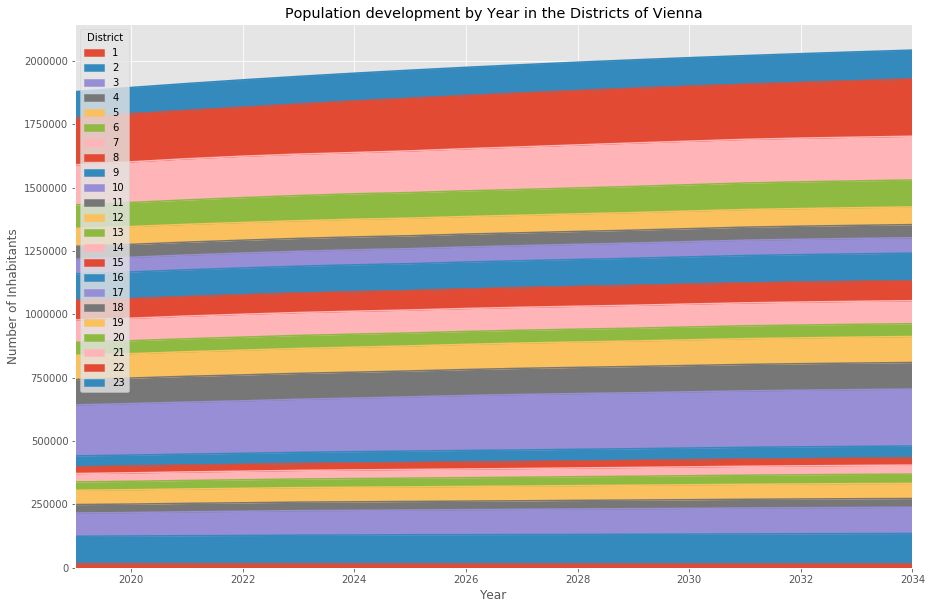

In [231]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

#df_pop_byyear.index = df_pop_byyear.index.map(int) # let's change the index values of df_top5 to type integer for plotting
df_pop_byyear.plot(kind='area', 
             stacked=True,
             figsize=(15, 10), 
             )

plt.title('Population development by Year in the Districts of Vienna')
plt.ylabel('Number of Inhabitants')
plt.xlabel('Year')

plt.show()


While looking at the population development per district over all the years is nice, it might be more helpful to see the change between now (2019) and 15 years in the future (2034). For this purpose, we'll create a new dataframe containing only those years.

In [232]:
df_pop_dev = df_pop[df_pop['Year'].isin([2019, 2034])]
df_pop_dev = pd.DataFrame(df_pop_dev.pivot(index='District', columns='Year', values='Population').to_records())
df_pop_dev = df_pop_dev.rename(columns={'2019':'Population2019', '2034':'Population2034'})
df_pop_dev['PopulationChangePrc'] = round((df_pop_dev['Population2034']-df_pop_dev['Population2019'])*100/df_pop_dev['Population2019'],2)
df_pop_dev

,District,Population2019,Population2034,PopulationChangePrc
0,1,15958,14628,-8.33
1,2,108651,120833,11.21
2,3,91915,103546,12.65
3,4,33190,34567,4.15
4,5,56462,59692,5.72
5,6,32902,36659,11.42
6,7,33129,35503,7.17
7,8,26422,28373,7.38
8,9,43160,46961,8.81
9,10,201388,224691,11.57


#### Pharmacy locations
Let's first take a look at how many pharmacies there are today in the respective districts of Vienna.

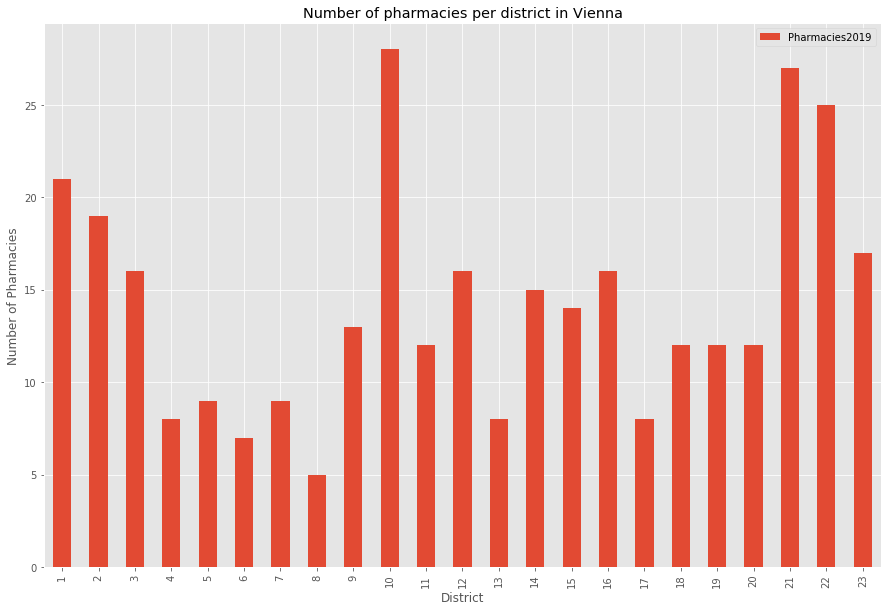

In [234]:
df_pharm_count = pd.DataFrame(df_pharm_clean.groupby('District').count()[['geometry']].to_records())
df_pharm_count = df_pharm_count.rename(columns={'geometry':'Pharmacies2019'})
##df_pharm_count.drop([''])

df_pharm_count.plot(kind='bar', 
             stacked=True,
             figsize=(15, 10), 
             x='District',
             y='Pharmacies2019'
             )

plt.title('Number of pharmacies per district in Vienna')
plt.ylabel('Number of Pharmacies')
plt.xlabel('District')

plt.show()


Now that we know how many pharmacies there are per district, let's plot them on a map to get a more visual impression.

In [263]:
# create a new map of Vienna
df_dist.to_file("vienna.geojson", driver='GeoJSON')
f = open('vienna.geojson', 'r')
vienna_json = f.read()
f.close()
#print(vienna_json)
#print(df_dist.to_json())
vienna_map = folium.Map(location=[latitude, longitude], zoom_start=11)



# instantiate a feature group for the pharmacies in the dataframe
pharmacies = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(df_pharm_clean.Latitude, df_pharm_clean.Longitude):
    pharmacies.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pharmacies to map
vienna_map.add_child(pharmacies)

vienna_map.choropleth(
    geo_data=vienna_json,
    name='Income Tax Per Capita',
    data=df_pharm_count,
    columns=['District'],
    fill_color='YlGn',
    key_on='features.properties.BEZNR',
    legend_name='number of Parmacies'
)

vienna_map

IndexError: list index out of range

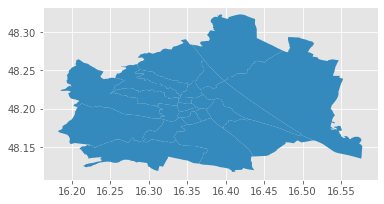

In [215]:

# create a new map of Vienna
#vienna_map2 = folium.Map(location=[latitude, longitude], zoom_start=11)
vienna_map2 = folium.Map(location=[0,0], zoom_start=11)


#!wget "https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:BEZIRKSGRENZEOGD&srsName=EPSG:4326&outputFormat=json" -O vienna.json
#vienna_json=r'vienna.json'

#vienna_map2.choropleth(geo_data=r'vienna.json')

df1 = gpd.read_file('vienna.json')
df1.plot()

#vienna_map2

#### District Analysis

Now let's combine the population data with pharmacy data to see how many people a pharmacy has to serve in each of the districts.

In [66]:
df_pharm_dev = pd.merge(df_pop_dev, df_pharm_count, how='inner', on='District')
df_pharm_dev['Density2019'] = (df_pharm_dev['Population2019']/df_pharm_dev['Pharmacies2019']).astype(int)
df_pharm_dev['Density2034'] = (df_pharm_dev['Population2034']/df_pharm_dev['Pharmacies2019']).astype(int)
df_pharm_dev['DensityChangePrc'] = round((df_pharm_dev['Density2034']-df_pharm_dev['Density2019'])*100/df_pharm_dev['Density2034'],2)
df_pharm_dev['Pharmacies2034'] = round(df_pharm_dev['Pharmacies2019']/df_pharm_dev['Population2019']*df_pharm_dev['Population2034'],0).astype(int)
df_pharm_dev['PharmaciesChangeAbs'] = df_pharm_dev['Pharmacies2034']-df_pharm_dev['Pharmacies2019']
df_pharm_dev

,District,Population2019,Population2034,PopulationChangePrc,Pharmacies2019,Density2019,Density2034,DensityChangePrc,Pharmacies2034,PharmaciesChangeAbs
0,1,15958,14628,-8.33,21,759,696,-9.05,19,-2
1,2,108651,120833,11.21,19,5718,6359,10.08,21,2
2,3,91915,103546,12.65,16,5744,6471,11.23,18,2
3,4,33190,34567,4.15,8,4148,4320,3.98,8,0
4,5,56462,59692,5.72,9,6273,6632,5.41,10,1
5,6,32902,36659,11.42,7,4700,5237,10.25,8,1
6,7,33129,35503,7.17,9,3681,3944,6.67,10,1
7,8,26422,28373,7.38,5,5284,5674,6.87,5,0
8,9,43160,46961,8.81,13,3320,3612,8.08,14,1
9,10,201388,224691,11.57,28,7192,8024,10.37,31,3


## Results 
you discuss the results.


## Discussion 
you discuss any observations you noted and any recommendations you can make based on the results.


## Conclusion 
you conclude the report.
